In [180]:
import numpy as np
import torch
import torch.nn as nn
from scipy import interpolate
import scipy
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from tqdm import tqdm

from vanilla_fem import *
from pod_fem import *
from deim_fem import *
from neim_fem2 import *
from other_functions import *

## Parameters
The parameters which we will let vary are $a$ so that
$$
    (a,) \in \mathbb{P} = [-0.5, 0.5].
$$

In [222]:
parameters = []
for a in np.linspace(-0.5, 0.5, 10):
    parameters.append((a,))

b = 0.5
c = 1
A0 = 0.5
M = 1
L = 0.1

# number of time steps and final time
Nt = 80
t_final = 4
tVals = np.linspace(0, t_final, Nt)
dt = tVals[1] - tVals[0] # delta t

In [223]:
# define the mesh in space
mesh, interior_point_coords = get_triangulation(refinements=5)

# Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)

## Solve High Fidelity PDE
Note that we only keep track of nodes in the interior of $\Omega$ because we use homogeneous Dirichlet boundary conditions.

In [224]:
hf_solutions = []
for (a,) in parameters:
    # Get vectors for the components of matrices (flattened over space) 
    # over time with time 0 initialized.
    Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)

    # solve the PDE (updates the entries of Q1, Q2, etc. within the function)
    solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)
    
    hf_solutions.append((Q1, Q2, p1, p2, r))

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 101.58it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 102.67it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.25it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.76it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.24it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.11it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 102.58it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.53it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.70it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.70it/s]


## Compute POD Matrices

In [5]:
Q1 = []
Q2 = []
p1 = []
p2 = []
r  = []
for sol in hf_solutions:
    Q1.append(sol[0])
    Q2.append(sol[1])
    p1.append(sol[2])
    p2.append(sol[3])
    r.append(sol[4])

Q1 = np.concatenate(Q1, axis=0)
Q2 = np.concatenate(Q2, axis=0)
p1 = np.concatenate(p1, axis=0)
p2 = np.concatenate(p2, axis=0)
r  = np.concatenate(r, axis=0)

max_rank = 5
U_Q1, U_Q2, U_r = get_POD_matrices(Q1, Q2, r, max_rank)

## Compare POD Solution to High Fidelity Solution (New Parameter)

In [6]:
a = -0.2

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

Q1_pod, Q2_pod, p1_pod, p2_pod, r_pod = initialize_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, U_Q1, U_Q2, U_r)
solve_Q_flow_POD(Q1_pod, Q2_pod, p1_pod, p2_pod, r_pod, gamma, stiffness_matrix, U_Q1, U_Q2, U_r, Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_pod.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 106.61it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 992.62it/s]


Relative Error: 0.021357009137760282


## Compute DEIM Operators

In [7]:
deim_modes = 7

nonlinearityQ = M * gamma.reshape(-1, 1) * np.concatenate([p1 * r, p2 * r], axis=0).T
UN_Q, nQ_indices = get_DEIM_operators(nonlinearityQ, deim_modes)
U_deimQ1 = U_Q1.T @ UN_Q
U_deimQ2 = U_Q2.T @ UN_Q

nonlinearityR = (2 * p1[:-1] * (Q1[1:] - Q1[:-1]) + 2 * p2[:-1] * (Q2[1:] - Q2[:-1])).T
UN_R, nR_indices = get_DEIM_operators(nonlinearityR, deim_modes)
U_deimR = U_r.T @ UN_R

## Compare DEIM Solution to High Fidelity Solution (New Parameter)

In [43]:
a = -0.15

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim = initialize_Q_flow_DEIM(Q1_, Q2_, p1_, p2_, r_, 
                                                                                          U_Q1, U_Q2, U_r, 
                                                                                          nQ_indices, nR_indices)
solve_Q_flow_DEIM(Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim, 
                    gamma, stiffness_matrix, 
                    U_Q1, U_Q2, U_r, U_deimQ1, U_deimQ2, U_deimR,
                    nQ_indices, nR_indices,
                    Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 147.01it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2927.38it/s]


Relative Error: 0.02165525385537883


## Compute NEIM Operators

### $Q$ Equation NEIM

In [32]:
time_frequency = 1
mu = []
"""
for (a, b, c) in parameters:
    for t in range(0, 5, time_frequency):#Nt, time_frequency):
        mu.append([t, a, b, c])
"""
for (a,) in parameters:
    for t in range(0, Nt, time_frequency):
        mu.append([t, a])
mu = np.array(mu)

num_time_params = len(range(0, Nt, time_frequency))

In [33]:
ro_sols = np.zeros((mu.shape[0], 3*max_rank))
f_NEIM  = np.zeros((mu.shape[0], mu.shape[0], 2*max_rank))

# iterate over solution parameter
for i, param1 in enumerate(mu):
    Q1_, Q2_, _, _, r_ = hf_solutions[i // num_time_params]
    Q1_, Q2_, r_ = Q1_[i % num_time_params], Q2_[i % num_time_params], r_[i % num_time_params]
    
    ro_sols[i] = np.concatenate([Q1_ @ U_Q1, Q2_ @ U_Q2, r_ @ U_r])
    
    # iterate over nonlinearity parameter
    for j, param2 in enumerate(mu):
        # evaluate Nonlinearity(solution(param1); param2)
        (t, a) = param2
        
        Q = np.concatenate((
                np.concatenate((Q1_[:, None, None], Q2_[:, None, None]), axis=2),
                np.concatenate((Q2_[:, None, None], -Q1_[:, None, None]), axis=2),
        ), axis=1)
        PQ = P(Q, a, b, c, A0)
        p1_ = PQ[:, 0, 0]
        p2_ = PQ[:, 0, 1]
        
        nonlinearityQ = M * np.concatenate([(gamma[None] * p1_ * r_) @ U_Q1, (gamma[None] * p2_ * r_) @ U_Q2], axis=1)
        f_NEIM[i, j] = nonlinearityQ.reshape(-1)

In [34]:
NQ_NEIM, _, _, _, _ = NEIM_Q(ro_sols, f_NEIM, mu, max_modes=7, train_loop_iterations=10000, theta_train_loop_iterations=30000)

720 Max Error: 0.011332902983674195 Mean Error: 0.00011011143444726854
0 24.661535372436045
100 0.0003819390002203313
200 0.00013819709728134412
300 0.00010815617726351956
400 8.460274787829486e-05
500 6.760826276002272e-05
600 5.57494318308292e-05
700 4.737261648453961e-05
800 4.1147934145455424e-05
900 3.618997183711548e-05
1000 3.199068719239931e-05
1100 2.828883567213769e-05
1200 2.4965621472000986e-05
1300 2.19663892503561e-05
1400 1.9265286872944737e-05
1500 1.684428765411089e-05
1600 1.4688620294939642e-05
1700 1.2779131214834905e-05
1800 1.1098421928422711e-05
1900 9.626957001919982e-06
2000 8.345113527406574e-06
2100 7.233827660099085e-06
2200 6.27490553863355e-06
2300 5.451014130833264e-06
2400 4.746988711862743e-06
2500 4.1874743910047435e-06
2600 3.7148367034978146e-06
2700 3.333525627997915e-06
2800 3.0059707474306836e-06
2900 2.74684877853735e-06
3000 2.5283393117511573e-06
3100 2.3349806061298136e-06
3200 2.1592822369315145e-06
3300 2.0191249994390426e-06
3400 1.89005517

8900 4.0740042419561315e-06
9000 3.975444485483732e-06
9100 3.89824263846706e-06
9200 3.8256660639619625e-06
9300 3.754320449043669e-06
9400 3.7976681336355445e-06
9500 3.619000754568835e-06
9600 3.5536206559189933e-06
9700 3.492362040095783e-06
9800 3.4300160255084643e-06
9900 3.368915216095867e-06

Finding theta...
Mean Already Selected Error: 2.176757697797327e-06
722 Max Error: 2.120166863111849e-05 Mean Error: 1.2934378771497822e-06
0 27.440751895753667
100 0.0009535789859390841
200 0.00044019376405201227
300 0.0002552114540836374
400 0.00015053097354133138
500 9.538735569846191e-05
600 6.5593403335976e-05
700 4.8075123894428804e-05
800 3.687288011794338e-05
900 2.9312916622022428e-05
1000 2.4052445465593e-05
1100 2.030751109022025e-05
1200 1.758287484036359e-05
1300 1.555236458204818e-05
1400 1.3999542900289798e-05
1500 1.2776784266597299e-05
1600 1.1782946127611667e-05
1700 1.0949479217679615e-05
1800 1.0228594893365257e-05
1900 9.588703082609097e-06
2000 9.008435794298865e-06
2

7500 8.642907507794207e-05
7600 8.42234987754078e-05
7700 8.200748072866537e-05
7800 7.978389112269169e-05
7900 8.06526801773475e-05
8000 7.555241430048203e-05
8100 7.353756914652885e-05
8200 7.163746039794117e-05
8300 6.981393320859474e-05
8400 6.803004102311222e-05
8500 6.636603254559059e-05
8600 6.470764740869728e-05
8700 6.31758219239402e-05
8800 6.166902206979866e-05
8900 6.039872491329707e-05
9000 5.884054827430241e-05
9100 5.746911559536205e-05
9200 5.6262608665400116e-05
9300 5.513105230844664e-05
9400 5.400348539220775e-05
9500 5.286772348397639e-05
9600 5.172794483624388e-05
9700 5.0757731130125215e-05
9800 4.95883894628705e-05
9900 4.855425074030228e-05

Finding theta...
Mean Already Selected Error: 1.2790510340267722e-06
640 Max Error: 3.236046606666883e-06 Mean Error: 1.9349914688649068e-07
0 58.13681361156701
100 0.008148622217732573
200 0.00746065342794863
300 0.007321235849849185
400 0.007184042833759219
500 0.007057682464056615
600 0.006945913206821561
700 0.0068493668

17100 2.354043999730493e-07
17200 2.330727397747978e-07
17300 2.3077532773640996e-07
17400 2.2852628944747266e-07
17500 2.260226352746031e-07
17600 2.2375101593752333e-07
17700 2.21401634803442e-07
17800 2.1922994619671954e-07
17900 2.169797568285503e-07
18000 2.1208730061061942e-07
18100 2.0265423472665134e-07
18200 1.9698002517998248e-07
18300 1.9336698642291594e-07
18400 1.902948980614383e-07
18500 1.8740912821613165e-07
18600 1.8479913421742822e-07
18700 1.8222522157884669e-07
18800 1.7969873056244978e-07
18900 1.744384405810706e-07
19000 1.690983708613203e-07
19100 1.6558182380776998e-07
19200 1.6301761718295893e-07
19300 1.593943892430616e-07
19400 1.5647451334643847e-07
19500 1.5375319151189615e-07
19600 1.5147912790780538e-07
19700 1.4936644276986044e-07
19800 1.474088406894225e-07
19900 1.4490700550595648e-07
20000 1.4283304494711047e-07
20100 1.410087264730464e-07
20200 1.3921901143021387e-07
20300 1.375586577978538e-07
20400 1.3572785917403962e-07
20500 1.3409953680820763e-0

### $r$ Equation NEIM

In [35]:
time_frequency = 1
mu = []
"""
for (a, b, c) in parameters:
    for t in range(0, 5-1, time_frequency):#Nt-1, time_frequency):
        mu.append([t, a, b, c])
"""
for (a,) in parameters:
    for t in range(0, Nt-1, time_frequency):
        mu.append([t, a])
mu = np.array(mu)

num_time_params = len(range(0, Nt-1, time_frequency))

In [36]:
ro_sols = np.zeros((mu.shape[0], 4*max_rank))
f_NEIM  = np.zeros((mu.shape[0], mu.shape[0], max_rank))

# iterate over solution parameter
for i, param1 in enumerate(mu):
    Q1_, Q2_, _, _, r_ = hf_solutions[i // num_time_params]
    time_idx = i % num_time_params
    
    Q1_0, Q2_0, r_0 = Q1_[time_idx], Q2_[time_idx], r_[time_idx]
    Q1_1, Q2_1, r_1 = Q1_[time_idx+1], Q2_[time_idx+1], r_[time_idx+1]
    
    ro_sols[i] = np.concatenate([Q1_1 @ U_Q1, Q1_0 @ U_Q1, Q2_1 @ U_Q2, Q2_0 @ U_Q2])
    
    # iterate over nonlinearity parameter
    for j, param2 in enumerate(mu):
        # evaluate Nonlinearity(solution(param1); param2)
        (t, a) = param2
        
        Q = np.concatenate((
                np.concatenate((Q1_0[:, None, None], Q2_0[:, None, None]), axis=2),
                np.concatenate((Q2_0[:, None, None], -Q1_0[:, None, None]), axis=2),
        ), axis=1)
        PQ = P(Q, a, b, c, A0)
        p1_ = PQ[:, 0, 0]
        p2_ = PQ[:, 0, 1]
        
        nonlinearityR = (2 * p1_ * (Q1_1 - Q1_0) + 2 * p2_ * (Q2_1 - Q2_0)) @ U_r
        f_NEIM[i, j] = nonlinearityR.reshape(-1)

In [37]:
NR_NEIM, _, _, _, _ = NEIM_R(ro_sols, f_NEIM, mu, max_modes=7, train_loop_iterations=10000, theta_train_loop_iterations=30000)

711 Max Error: 0.5859846229095036 Mean Error: 0.004644995173313689
0 0.020187226587352402
100 8.37744121450502e-05
200 3.1757835644379904e-06
300 1.4301868690713704e-06
400 7.500381090797859e-07
500 5.113318557803954e-07
600 3.690127843173605e-07
700 2.822306279660077e-07
800 2.2793258392170385e-07
900 1.8958338778104377e-07
1000 1.5954794699343238e-07
1100 1.3788959988169025e-07
1200 1.2391765673519446e-07
1300 1.1403207734720268e-07
1400 1.0648045644558513e-07
1500 1.0024045409690955e-07
1600 9.460322448075877e-08
1700 8.981760379020677e-08
1800 8.563633135447133e-08
1900 8.189716894447066e-08
2000 7.848946683136415e-08
2100 7.533926563225727e-08
2200 7.239793776724507e-08
2300 6.962403495127027e-08
2400 6.69817640038432e-08
2500 6.424992137670143e-08
2600 6.164212889140346e-08
2700 5.913051683205682e-08
2800 5.669522774325927e-08
2900 5.4379534065595864e-08
3000 5.2164203478162e-08
3100 4.993977063243856e-08
3200 4.757918731964375e-08
3300 4.528385368388523e-08
3400 4.30444775844914

8800 1.493475471934067e-07
8900 1.4873908632603393e-07
9000 1.4812693574190908e-07
9100 1.4752370120476896e-07
9200 1.4693786852775845e-07
9300 1.4638034537925273e-07
9400 1.4579411745995042e-07
9500 1.4523305525838918e-07
9600 1.4468236573679322e-07
9700 1.441452297425308e-07
9800 1.4360583099568812e-07
9900 1.430775284443831e-07

Finding theta...
Mean Already Selected Error: 0.00023225586864667475
79 Max Error: 0.000632320233483214 Mean Error: 4.791347587153376e-06
0 0.02822287541974035
100 0.001700852718886238
200 0.0013261810592666266
300 0.000940951214145965
400 0.0006501876865953341
500 0.0005423289408153152
600 0.0004980511776959363
700 0.0004625633145524247
800 0.00042939142226452374
900 0.0004009679616014086
1000 0.0003773828749229409
1100 0.00035509433859487856
1200 0.0003285055793734607
1300 0.00030477251916427714
1400 0.0002877287533701603
1500 0.00026522595937870865
1600 0.00024920092195082215
1700 0.0002335628893151136
1800 0.0002123707357833472
1900 0.0001913746331272464

7700 0.0017961309151489897
7800 0.0017961295421750419
7900 0.0017961246944896078
8000 0.0017961251363227458
8100 0.0017961213508837556
8200 0.0017961178432499296
8300 0.0017961145757186322
8400 0.0017961092244372324
8500 0.0017961065382414432
8600 0.0017961020240698997
8700 0.0017960964821350188
8800 0.0017960921049542
8900 0.001796089076376662
9000 0.0017960836742557122
9100 0.0017960751847959317
9200 0.0017960750445391678
9300 0.0017960684872121737
9400 0.0017960633041808455
9500 0.0017960571310161448
9600 0.0017960481245452833
9700 0.0017960455570877286
9800 0.00179603649754501
9900 0.0017960299277908966

Finding theta...
Mean Already Selected Error: 0.0003884379769090887
316 Max Error: 0.0004948171915436553 Mean Error: 2.0990844091084363e-06
0 0.024856162879185358
100 0.011907164374993735
200 0.010040395803334566
300 0.008882832942264912
400 0.007590329401765501
500 0.006799407325682273
600 0.00610568933006622
700 0.00536768275638428
800 0.004602101727055195
900 0.00391159073098314

17200 4.845484227189445e-07
17300 4.808383096133184e-07
17400 4.772961119670072e-07
17500 4.736607195354736e-07
17600 4.7033557848408236e-07
17700 4.673022999668319e-07
17800 4.6422934474321664e-07
17900 4.613600310676702e-07
18000 4.586083264257468e-07
18100 4.5585065322484297e-07
18200 4.5309857910069695e-07
18300 4.5050401809021423e-07
18400 4.480687323393795e-07
18500 4.4581349811778637e-07
18600 4.4344415073283017e-07
18700 4.410371445828787e-07
18800 4.3781849967672315e-07
18900 4.3521254156075884e-07
19000 4.3281582406962116e-07
19100 4.3057096377197013e-07
19200 4.2827221591323905e-07
19300 4.260899686414632e-07
19400 4.2394333377160365e-07
19500 4.2181179082945164e-07
19600 4.1983133769463166e-07
19700 4.177675236860523e-07
19800 4.158471824666776e-07
19900 4.140837290833588e-07
20000 4.1239115944335936e-07
20100 4.108165398974961e-07
20200 4.090293828085123e-07
20300 4.0751896790425235e-07
20400 4.0601926798444765e-07
20500 4.0459229921907536e-07
20600 4.031473963550525e-07
2

## Compare NEIM Solution to High Fidelity Solution (New Parameter)

In [52]:
a = -0.15

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

with torch.no_grad():

    Q1_neim, Q2_neim, r_neim = initialize_Q_flow_NEIM(Q1_, Q2_, r_, U_Q1, U_Q2, U_r)

    solve_Q_flow_NEIM(Q1_neim, Q2_neim, r_neim, 
                        gamma, stiffness_matrix, 
                        U_Q1, U_Q2, NQ_NEIM, NR_NEIM,
                        Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 130.58it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 576.55it/s]


Relative Error: 0.0671269945780835


## DEIM-NEIM Comparison

In [75]:
def solve_deim_neim(a = 0.):

    Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
    solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

    Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim = initialize_Q_flow_DEIM(Q1_, Q2_, p1_, p2_, r_, 
                                                                                              U_Q1, U_Q2, U_r, 
                                                                                              nQ_indices, nR_indices)
    solve_Q_flow_DEIM(Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim, 
                        gamma, stiffness_matrix, 
                        U_Q1, U_Q2, U_r, U_deimQ1, U_deimQ2, U_deimR,
                        nQ_indices, nR_indices,
                        Nt, a, b, c, A0, M, L, dt)

    print("Relative Error (DEIM):", np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))


    with torch.no_grad():

        Q1_neim, Q2_neim, r_neim = initialize_Q_flow_NEIM(Q1_, Q2_, r_, U_Q1, U_Q2, U_r)

        solve_Q_flow_NEIM(Q1_neim, Q2_neim, r_neim, 
                            gamma, stiffness_matrix, 
                            U_Q1, U_Q2, NQ_NEIM, NR_NEIM,
                            Nt, a, b, c, A0, M, L, dt)

    print("Relative Error (NEIM):", np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))
    
    return Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim

In [76]:
Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(0.0)

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.35it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2633.86it/s]


Relative Error (DEIM): 0.02011321646438514
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 560.30it/s]


Relative Error (NEIM): 0.04652154831765948


In [77]:
error_time_neim = [np.linalg.norm(Q1_[time] - (U_Q1 @ Q1_neim.T).T[time]) / np.linalg.norm(Q1_[time]) for time in range(Q1_.shape[0])]

In [78]:
error_time_deim = [np.linalg.norm(Q1_[time] - (U_Q1 @ Q1_deim.T).T[time]) / np.linalg.norm(Q1_[time]) for time in range(Q1_.shape[0])]

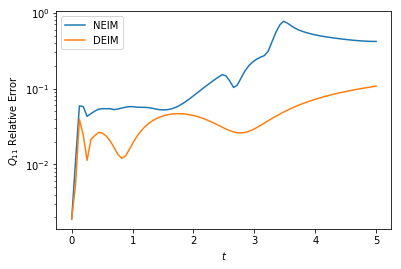

In [84]:
plt.semilogy(tVals, error_time_neim, label="NEIM")
plt.semilogy(tVals, error_time_deim, label="DEIM")
plt.xlabel("$t$")
plt.ylabel("$Q_{11}$ Relative Error")
plt.legend()
plt.show()

In [85]:
a_list = np.arange(-0.5, 0.55, 0.05)
error_deim = []
error_neim = []
for a in a_list:
    Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a)
    error_deim.append(np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))
    error_neim.append(np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.01it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2633.48it/s]


Relative Error (DEIM): 0.05484308669014979
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 392.96it/s]


Relative Error (NEIM): 0.05764583254959905
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.57it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1611.30it/s]


Relative Error (DEIM): 0.04562320646252681
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 352.67it/s]


Relative Error (NEIM): 0.06879956763633022
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.53it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2052.16it/s]


Relative Error (DEIM): 0.03822959516261388
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 396.92it/s]


Relative Error (NEIM): 0.06983572267909627
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.80it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1928.42it/s]


Relative Error (DEIM): 0.03248725645838198
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 352.26it/s]


Relative Error (NEIM): 0.06607584577996369
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.06it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2545.36it/s]


Relative Error (DEIM): 0.02819162192547782
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 464.70it/s]


Relative Error (NEIM): 0.06314904697786097
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.81it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2468.86it/s]


Relative Error (DEIM): 0.02511478574881669
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 411.39it/s]


Relative Error (NEIM): 0.061954621247816435
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 106.14it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2548.53it/s]


Relative Error (DEIM): 0.023015103946770272
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 473.04it/s]


Relative Error (NEIM): 0.06314338334943276
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.55it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2323.52it/s]


Relative Error (DEIM): 0.02165525385537882
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 454.03it/s]


Relative Error (NEIM): 0.06712699457808342
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.59it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2633.71it/s]


Relative Error (DEIM): 0.02082399738196952
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 422.39it/s]


Relative Error (NEIM): 0.07484633991321354
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.06it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2192.32it/s]


Relative Error (DEIM): 0.020351544139279032
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 422.39it/s]


Relative Error (NEIM): 0.0673626102292969
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.15it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1881.54it/s]


Relative Error (DEIM): 0.02011321646438514
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 441.36it/s]


Relative Error (NEIM): 0.04652154831765946
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 106.78it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2724.38it/s]


Relative Error (DEIM): 0.020023828153321915
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 478.77it/s]


Relative Error (NEIM): 0.0790438679153008
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 113.26it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2723.53it/s]


Relative Error (DEIM): 0.02002820241269475
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 481.69it/s]


Relative Error (NEIM): 0.068291331196462
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 101.74it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2723.24it/s]


Relative Error (DEIM): 0.020091897828477822
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 475.92it/s]


Relative Error (NEIM): 0.07368614446319775
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 109.80it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2394.82it/s]


Relative Error (DEIM): 0.020193888180415176
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 448.75it/s]


Relative Error (NEIM): 0.08696697621204348
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.38it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2103.80it/s]


Relative Error (DEIM): 0.020321423962635036
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 526.68it/s]


Relative Error (NEIM): 0.09466511723841763
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.74it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2633.11it/s]


Relative Error (DEIM): 0.0204666828634713
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 492.16it/s]


Relative Error (NEIM): 0.09879496492483741
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 108.23it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2633.92it/s]


Relative Error (DEIM): 0.020624699252036215
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 484.64it/s]


Relative Error (NEIM): 0.09920319036974388
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 108.71it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2083.48it/s]


Relative Error (DEIM): 0.02079213909134591
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 422.38it/s]


Relative Error (NEIM): 0.09774602961473247
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.22it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3160.08it/s]


Relative Error (DEIM): 0.020966604418972776
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 519.73it/s]


Relative Error (NEIM): 0.09757792068975843
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.04it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2629.41it/s]


Relative Error (DEIM): 0.021146255139472853
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 478.61it/s]


Relative Error (NEIM): 0.11001972641853648


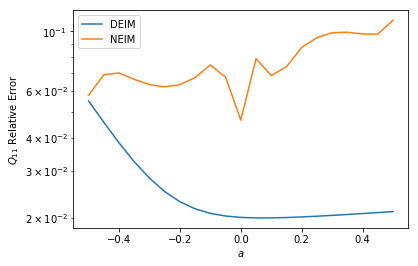

In [87]:
plt.semilogy(a_list, error_deim, label="DEIM")
plt.semilogy(a_list, error_neim, label="NEIM")
plt.xlabel("$a$")
plt.ylabel("$Q_{11}$ Relative Error")
plt.legend()
plt.show()

In [122]:
a_list = np.arange(-0.5, 0.55, 0.05)
error_deim_contour = []
error_neim_contour = []
for a in a_list:
    error_deim_contour.append([])
    error_neim_contour.append([])
    
    Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a)
    
    for i, t in enumerate(tVals):
        error_deim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_deim.T).T[i]) / np.linalg.norm(Q1_[i]))
        error_neim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_neim.T).T[i]) / np.linalg.norm(Q1_[i]))

a_contour, time_contour = np.meshgrid(tVals, a_list)

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 135.74it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3292.20it/s]


Relative Error (DEIM): 0.05484308669014979
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 612.41it/s]


Relative Error (NEIM): 0.05764583254959905
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 129.93it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3159.69it/s]


Relative Error (DEIM): 0.04562320646252681
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 598.48it/s]


Relative Error (NEIM): 0.06879956763633022
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 136.39it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2926.19it/s]


Relative Error (DEIM): 0.03822959516261388
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 622.11it/s]


Relative Error (NEIM): 0.06983572267909627
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 135.73it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2818.06it/s]


Relative Error (DEIM): 0.03248725645838198
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 579.97it/s]


Relative Error (NEIM): 0.06607584577996369
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 135.28it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3591.48it/s]


Relative Error (DEIM): 0.02819162192547782
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 675.22it/s]


Relative Error (NEIM): 0.06314904697786097
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 135.47it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2467.83it/s]


Relative Error (DEIM): 0.02511478574881669
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 622.02it/s]


Relative Error (NEIM): 0.061954621247816435
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.32it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3291.77it/s]


Relative Error (DEIM): 0.023015103946770272
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 642.29it/s]


Relative Error (NEIM): 0.06314338334943276
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 136.70it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3158.72it/s]


Relative Error (DEIM): 0.02165525385537882
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 603.06it/s]


Relative Error (NEIM): 0.06712699457808342
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 128.87it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3165.03it/s]


Relative Error (DEIM): 0.02082399738196952
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 593.92it/s]


Relative Error (NEIM): 0.07484633991321354
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.60it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3749.28it/s]


Relative Error (DEIM): 0.020351544139279032
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 647.41it/s]


Relative Error (NEIM): 0.0673626102292969
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 133.90it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 3159.87it/s]


Relative Error (DEIM): 0.02011321646438514
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 669.51it/s]


Relative Error (NEIM): 0.04652154831765946
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 118.35it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2925.88it/s]


Relative Error (DEIM): 0.020023828153321915
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 512.85it/s]


Relative Error (NEIM): 0.0790438679153008
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.41it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1880.74it/s]


Relative Error (DEIM): 0.02002820241269475
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 431.62it/s]


Relative Error (NEIM): 0.068291331196462
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.99it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2633.40it/s]


Relative Error (DEIM): 0.020091897828477822
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 483.24it/s]


Relative Error (NEIM): 0.07368614446319775
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.31it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2548.47it/s]


Relative Error (DEIM): 0.020193888180415176
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 484.71it/s]


Relative Error (NEIM): 0.08696697621204348
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 114.46it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2391.38it/s]


Relative Error (DEIM): 0.020321423962635036
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 487.66it/s]


Relative Error (NEIM): 0.09466511723841763
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.53it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2817.53it/s]


Relative Error (DEIM): 0.0204666828634713
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 499.91it/s]


Relative Error (NEIM): 0.09879496492483741
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.51it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2925.31it/s]


Relative Error (DEIM): 0.020624699252036215
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 459.32it/s]


Relative Error (NEIM): 0.09920319036974388
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 114.83it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2079.07it/s]


Relative Error (DEIM): 0.02079213909134591
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 448.87it/s]


Relative Error (NEIM): 0.09774602961473247
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 112.05it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2630.58it/s]


Relative Error (DEIM): 0.020966604418972776
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 492.51it/s]


Relative Error (NEIM): 0.09757792068975843
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.80it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1835.52it/s]


Relative Error (DEIM): 0.021146255139472853
Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 472.94it/s]


Relative Error (NEIM): 0.11001972641853648


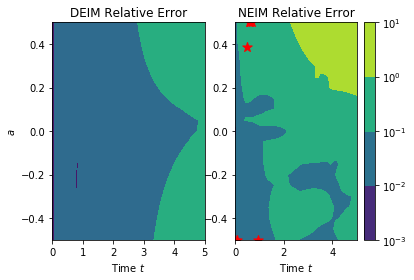

In [137]:
fig, ax = plt.subplots(1, 2)

ax[0].contourf(a_contour, time_contour, error_deim_contour, locator=ticker.LogLocator(), vmin=np.min(error_deim_contour), vmax=np.max(error_neim_contour))
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("$a$")
ax[0].set_title("DEIM Relative Error")

cs = ax[1].contourf(a_contour, time_contour, error_neim_contour, locator=ticker.LogLocator())
ax[1].set_xlabel("Time $t$")
ax[1].set_title("NEIM Relative Error")
ax[1].set_xlabel("Time $t$")
ax[1].scatter(np.array([9, 10, 0, 11, 15, 1, 8])*dt, np.array([0.5, 0.5, -0.5, 0.5, -0.5, -0.5, 0.388888888888]), s=100, color='r', marker="*")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
plt.colorbar(cs)
plt.show()

In [125]:
mu[720], mu[721], mu[0], mu[722], mu[15], mu[1], mu[640]

(array([9. , 0.5]),
 array([10. ,  0.5]),
 array([ 0. , -0.5]),
 array([11. ,  0.5]),
 array([15. , -0.5]),
 array([ 1. , -0.5]),
 array([8.        , 0.38888889]))

In [192]:
def solve_deim_neim_nonlinearities(a=0.):

    Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
    solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

    Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim = initialize_Q_flow_DEIM(Q1_, Q2_, p1_, p2_, r_, 
                                                                                              U_Q1, U_Q2, U_r, 
                                                                                              nQ_indices, nR_indices)
    hfQ_nonlinearities = []
    hfR_nonlinearities = []
    deimQ_nonlinearities = []
    deimR_nonlinearities = []
    neimQ_nonlinearities = []
    neimR_nonlinearities = []
    for t in range(Q1_.shape[0]-1):
        
        g1 = M * gamma * p1_[t] * r_[t]
        g2 = M * gamma * p2_[t] * r_[t]
        Q_nonlinearity = np.concatenate((g1, g2))
        R_nonlinearity = 2 * p1_[t] * (Q1_[t+1] - Q1_[t]) + 2 * p2_[t] * (Q2_[t+1] - Q2_[t])
        
        hfQ_nonlinearities.append(Q_nonlinearity)
        hfR_nonlinearities.append(R_nonlinearity)
        
        Q1_t = (U_Q1 @ U_Q1.T @ Q1_[t].reshape(-1, 1)).reshape(-1)
        Q2_t = (U_Q2 @ U_Q2.T @ Q2_[t].reshape(-1, 1)).reshape(-1)
        
        Q1_t1 = (U_Q1 @ U_Q1.T @ Q1_[t+1].reshape(-1, 1)).reshape(-1)
        Q2_t1 = (U_Q2 @ U_Q2.T @ Q2_[t+1].reshape(-1, 1)).reshape(-1)
        
        Q_t = np.concatenate((
                    np.concatenate((Q1_t[:, None, None], Q2_t[:, None, None]), axis=2),
                    np.concatenate((Q2_t[:, None, None], -Q1_t[:, None, None]), axis=2),
            ), axis=1)
        PQ = P(Q_t, a, b, c, A0)
        p1_t = PQ[:, 0, 0]
        p2_t = PQ[:, 0, 1]
        
        g1 = M * U_Q1 @ U_deimQ1 @ (gamma[nQ_indices].reshape(-1, 1) * p1_t[nQ_indices].reshape(-1, 1) * (U_r[nQ_indices] @ U_r.T @ r_[t].reshape(-1, 1)))
        g2 = M * U_Q2 @ U_deimQ2 @ (gamma[nQ_indices].reshape(-1, 1) * p2_t[nQ_indices].reshape(-1, 1) * (U_r[nQ_indices] @ U_r.T @ r_[t].reshape(-1, 1)))
    
        deimQ_nonlinearity = np.concatenate((g1.reshape(-1), g2.reshape(-1)))
        deimR_nonlinearity = (U_r @ (U_deimR @ (2*(p1_t * (Q1_t1 - Q1_t))[nR_indices].reshape(-1, 1)\
                             + 2*(p2_t * (Q2_t1 - Q2_t))[nR_indices].reshape(-1, 1)))).reshape(-1)
        
        deimQ_nonlinearities.append(deimQ_nonlinearity)
        deimR_nonlinearities.append(deimR_nonlinearity)

        with torch.no_grad():
            ro_sol = np.concatenate([U_Q1.T @ Q1_[t].reshape(-1, 1), U_Q2.T @ Q2_[t].reshape(-1, 1), U_r.T @ r_[t].reshape(-1, 1)], axis=0).reshape(-1)
            neimQ_nonlinearity = (scipy.linalg.block_diag(U_Q1, U_Q2) @ NQ_NEIM(np.array([t, a]), ro_sol).reshape(-1, 1)).reshape(-1)
            ro_sol = np.concatenate([U_Q1.T @ Q1_[t].reshape(-1, 1), U_Q1.T @ Q1_[t-1].reshape(-1, 1), 
                                     U_Q2.T @ Q2_[t].reshape(-1, 1), U_Q2.T @ Q2_[t-1].reshape(-1, 1)], axis=0).reshape(-1)
            neimR_nonlinearity = (U_r @ NR_NEIM(np.array([t-1, a]), ro_sol).reshape(-1, 1)).reshape(-1)

            neimQ_nonlinearities.append(neimQ_nonlinearity)
            neimR_nonlinearities.append(neimR_nonlinearity)
    
    hfQ_nonlinearities = np.array(hfQ_nonlinearities)
    deimQ_nonlinearities = np.array(deimQ_nonlinearities)
    deimR_nonlinearities = np.array(deimR_nonlinearities)
    neimQ_nonlinearities = np.array(neimQ_nonlinearities)
    neimR_nonlinearities = np.array(neimR_nonlinearities)
    
    return hfQ_nonlinearities, hfR_nonlinearities, deimQ_nonlinearities, deimR_nonlinearities, neimQ_nonlinearities, neimR_nonlinearities


# a_list = np.arange(-0.5, 0.55, 0.05)
# error_deim_contour = []
# error_neim_contour = []
# for a in a_list:
#     error_deim_contour.append([])
#     error_neim_contour.append([])
    
#     Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a)
    
#     for i, t in enumerate(tVals):
#         error_deim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_deim.T).T[i]) / np.linalg.norm(Q1_[i]))
#         error_neim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_neim.T).T[i]) / np.linalg.norm(Q1_[i]))

# a_contour, time_contour = np.meshgrid(tVals, a_list)

In [193]:
hfQ_nonlinearities, hfR_nonlinearities, deimQ_nonlinearities, deimR_nonlinearities, neimQ_nonlinearities, neimR_nonlinearities = solve_deim_neim_nonlinearities(a=0.15)

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 145.74it/s]


In [205]:
np.median(np.abs(deimR_nonlinearities - neimR_nonlinearities)), np.median(np.abs(hfR_nonlinearities))

(3.2423952299285955e-06, 1.6087106351762345e-08)

In [225]:
r

array([[1.01101999, 1.1843356 , 1.46120588, ..., 1.03988871, 1.05771782,
        1.05984811],
       [1.01035463, 1.08554854, 1.21954186, ..., 1.02529777, 1.03531048,
        1.03572057],
       [1.00887593, 1.03978682, 1.10865794, ..., 1.01613275, 1.02195361,
        1.02152999],
       ...,
       [0.99945795, 0.96975413, 0.92372635, ..., 0.99592233, 0.99380149,
        0.99316204],
       [0.99945786, 0.96975412, 0.92372631, ..., 0.99592231, 0.99380148,
        0.99316202],
       [0.99945778, 0.9697541 , 0.92372628, ..., 0.9959223 , 0.99380147,
        0.99316201]])